<a href="https://colab.research.google.com/github/oleksiyo/machine-learning-zoomcamp/blob/master/cohorts/2025/02-regression/Homework_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Machine Learning for Regression

The goal of this homework is to create a regression model for predicting the car fuel efficiency (column '***fuel_efficiency_mpg***').



## Data preparation

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-08 16:35:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.4’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.05s   

2025-10-08 16:35:26 (17.7 MB/s) - ‘car_fuel_efficiency.csv.4’ saved [874188/874188]



In [116]:
df_full = pd.read_csv('car_fuel_efficiency.csv')

In [117]:
df_full.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [118]:
for col in df_full.columns:
    print(col)
    print(df_full[col].unique()[:5])
    print(df_full[col].nunique())
    print()

engine_displacement
[170 130 220 210 190]
36

num_cylinders
[ 3.  5. nan  4.  1.]
14

horsepower
[159.  97.  78.  nan 140.]
192

vehicle_weight
[3413.43375861 3149.66493422 3079.03899737 2542.39240183 3460.87098999]
9704

acceleration
[17.7 17.8 15.1 20.2 14.4]
162

model_year
[2003 2007 2018 2009 2008]
24

origin
['Europe' 'USA' 'Asia']
3

fuel_type
['Gasoline' 'Diesel']
2

drivetrain
['All-wheel drive' 'Front-wheel drive']
2

num_doors
[ 0.  2. -1.  1. nan]
9

fuel_efficiency_mpg
[13.23172891 13.68821744 14.246341   16.9127356  12.48836912]
9704



In [119]:
df_full.isnull().sum()

,0
engine_displacement,0
num_cylinders,482
horsepower,708
vehicle_weight,0
acceleration,930
model_year,0
origin,0
fuel_type,0
drivetrain,0
num_doors,502


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

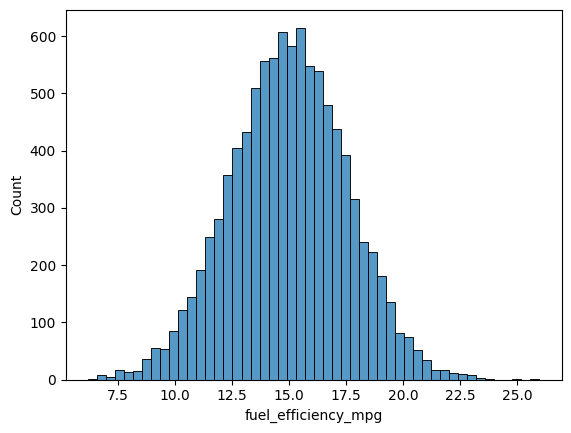

In [120]:
sns.histplot(df_full.fuel_efficiency_mpg, bins=50)

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

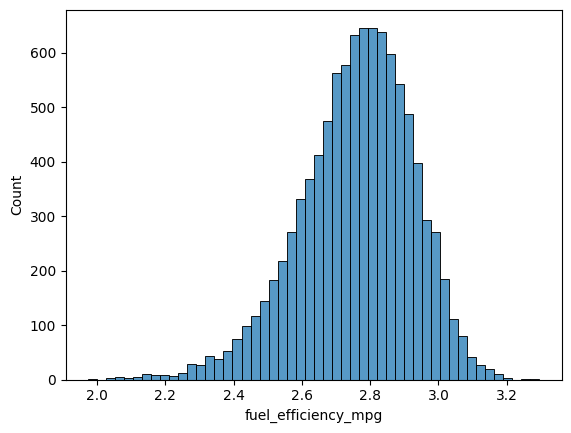

In [121]:
fe_mpg_logs = np.log1p(df_full.fuel_efficiency_mpg)
sns.histplot(fe_mpg_logs, bins=50)

In [122]:
# Keep only required columns
used_cols = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
df = df_full[used_cols].copy()

feature_cols = ['engine_displacement','horsepower','vehicle_weight','model_year']
target_col   = 'fuel_efficiency_mpg'

## Question 1. Missing values

In [123]:
na_cols = na_cols = df.columns[df.isna().any()].tolist()
answer_q1 = [c for c in feature_cols if c in na_cols]
print("Q1 answer:", answer_q1[0] if answer_q1 else "None")
missing_values_column_name = answer_q1[0]

Q1 answer: horsepower


## Question 2. Median for horse power

What's the median (50% percentile) for variable '**horsepower**'?

In [124]:
hp_median = df['horsepower'].median()
print("Horsepower median:", hp_median)

choices = np.array([49, 99, 149, 199])
closest = choices[np.argmin(np.abs(choices - hp_median))]

print("Q2 choice:", int(closest))

Horsepower median: 149.0
Q2 choice: 149


## Helpers

In [125]:
# Shuffle by seed and perform 60/20/20 split; return train/val/test dataframes
def split_60_20_20(df_in, seed):
    d = df_in.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n = len(d)
    n_train = int(0.6 * n)
    n_val   = int(0.2 * n)
    df_train = d.iloc[:n_train].copy()
    df_val   = d.iloc[n_train:n_train+n_val].copy()
    df_test  = d.iloc[n_train+n_val:].copy()
    return df_train, df_val, df_test

# Calculates the Root Mean Squared Error.
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def prepare_X(df_part, fill_value=0.0):
    """Build design matrix with bias column; fill all NaNs in features with a single value."""
    X = df_part[feature_cols].copy().fillna(fill_value).values
    ones = np.ones((X.shape[0], 1))
    return np.hstack([ones, X])

# Trains a linear regression model using the normal equation.
def train_linear_regression(X, y):
    # Add a bias term (column of ones) to the feature matrix
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])


    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

# Calculates the Root Mean Squared Error.
# def rmse(y_true, y_pred):
#     error = y_true - y_pred
#     mse = (error**2).mean()
#     return np.sqrt(mse)

## Question 3. Filling NAs

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [126]:
print("need to deal with missing values for the column: "+ missing_values_column_name)

need to deal with missing values for the column: horsepower


In [127]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
df_train, df_val, df_test = split_60_20_20(df, seed=42)
y_train = df_train[target_col].values
y_val   = df_val[target_col].values
y_test  = df_test[target_col].values

OPTION A: fill with **0**

In [128]:
# fill miss values as 0
X_train_0 = df_train[feature_cols].fillna(0).to_numpy()
y_train = df_train[target_col].to_numpy()

X_val_0 = df_val[feature_cols].fillna(0).to_numpy()
y_val = df_val[target_col].to_numpy()

# train model
w0_0, w_0 = train_linear_regression(X_train_0, y_train)

# predictions for the validation set
y_pred_0 = w0_0 + X_val_0.dot(w_0)

rmse_0 = round(rmse(y_val, y_pred_0), 2)
rmse_0

0.52

OPTION B: fill with **MEAN**

In [129]:
# Get mean of horsepower
horsepower_mean = df_train[missing_values_column_name].mean()

# add missing horsepower values
X_train_mean = df_train[feature_cols].fillna(horsepower_mean).to_numpy()
X_val_mean = df_val[feature_cols].fillna(horsepower_mean).to_numpy()

# train  model
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

# predictions for the validation set
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

# calculate and round the RMSE
rmse_mean = round(rmse(y_val, y_pred_mean), 2)
rmse_mean

0.46

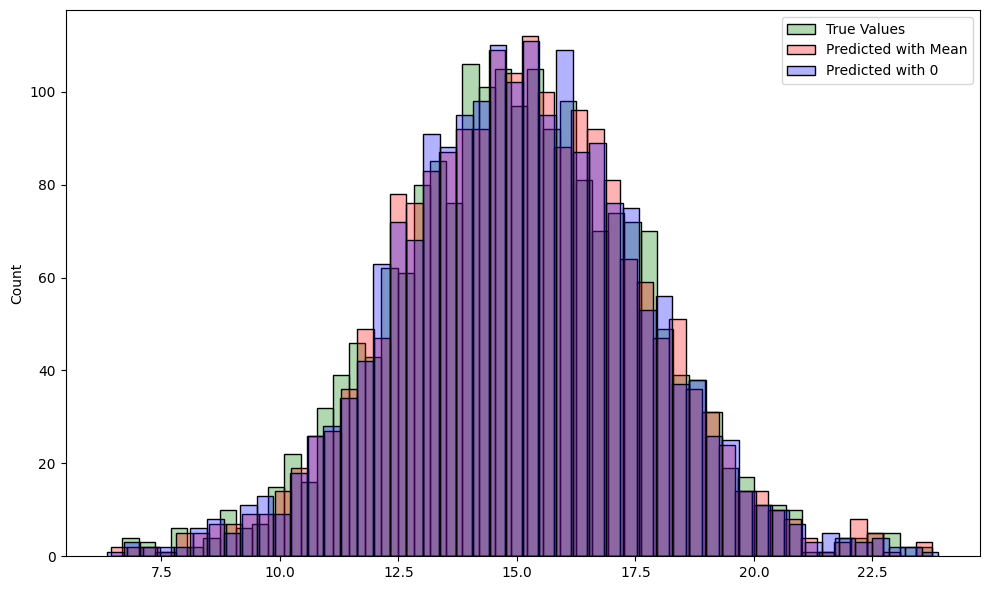

In [130]:
plt.figure(figsize=(10, 6))

sns.histplot(y_val, bins=50, color='green', alpha=0.3, label='True Values')
sns.histplot(y_pred_mean, bins=50, color='red', alpha=0.3, label='Predicted with Mean')
sns.histplot(y_pred_0, bins=50, color='blue', alpha=0.3, label='Predicted with 0')

plt.legend()

plt.tight_layout()
plt.show()

In [131]:
if rmse_mean < rmse_0:
    print(f"Mean values are better. RMSE: {rmse_mean}")
elif rmse_mean > rmse_0:
    print(f"Zero values are better. RMSE: {rmse_0}")
else:
    print(f"Both are equal. RMSE: {rmse_mean}")

Mean values are better. RMSE: 0.46


## Question 4. Best regularization
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [132]:
def train_linear_regression_reg(X, y, r=0.0):
    """
    Trains a regularized linear regression model using the normal equation.
    """
    # Add a bias term (column of ones)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # Normal equation with regularization: w = (X^T*X + r*I)^-1 * X^T*y
    XTX = X.T.dot(X)

    # Create the identity matrix for regularization
    reg = r * np.eye(XTX.shape[0])

    # Set the first element to 0 to not regularize the bias term
    # reg[0, 0] = 0

    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [133]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_values:
    # Train the regularized model
    w0, w = train_linear_regression_reg(X_train_0, y_train, r=r)

    # Make predictions on the validation set
    y_pred = w0 + X_val_0.dot(w)

    # Calculate and round the RMSE
    score = round(rmse(y_val, y_pred), 2)

    # Store the result
    rmse_scores[r] = score

    print(f"r = {r:<4} | RMSE = {score}")

r = 0    | RMSE = 0.52
r = 0.01 | RMSE = 0.52
r = 0.1  | RMSE = 0.52
r = 1    | RMSE = 0.52
r = 5    | RMSE = 0.52
r = 10   | RMSE = 0.52
r = 100  | RMSE = 0.52


In [134]:
def prepare_X_zero(df_part):
    """Build design matrix with bias column; fill all NaNs in features with 0."""
    X = df_part[feature_cols].copy().fillna(0.0).values
    ones = np.ones((X.shape[0], 1))  # bias term
    return np.hstack([ones, X])

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rounded_scores = {}

X_tr = prepare_X_zero(df_train)
X_va = prepare_X_zero(df_val)

for r in r_values:
    # Train the regularized model
    w0, w = train_linear_regression_reg(X_train_0, y_train, r=r)

    # Make predictions on the validation set
    y_pred = w0 + X_val_0.dot(w)

    # Calculate and round the RMSE
    score = round(rmse(y_val, y_pred), 2)

    # Store the result
    rounded_scores[r] = score


for r in r_values:
  print(f"r={r}: RMSE={rounded_scores[r]}")

# Select best r based on the rounded RMSE; break ties by picking the smallest r
best_rmse_rounded = min(rounded_scores.values())
best_candidates = [r for r, s in rounded_scores.items() if s == best_rmse_rounded]
best_r = min(best_candidates)
print()
print("Best RMSE (rounded):", best_rmse_rounded)
print("Q4 choice (best r):", best_r)

r=0: RMSE=0.52
r=0.01: RMSE=0.52
r=0.1: RMSE=0.52
r=1: RMSE=0.52
r=5: RMSE=0.52
r=10: RMSE=0.52
r=100: RMSE=0.52

Best RMSE (rounded): 0.52
Q4 choice (best r): 0


## Question 5. RMSE Standard Deviation
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [135]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
rmse_scores = []

for seed in seeds:
    df_train, df_val, df_test = split_60_20_20(df, seed)

    # Prepare data (fill missing values with 0)
    X_train = df_train[feature_cols].fillna(0).to_numpy()
    y_train = df_train[target_col].to_numpy()

    X_val = df_val[feature_cols].fillna(0).to_numpy()
    y_val = df_val[target_col].to_numpy()

    # Train the model (without regularization)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    # Calculate and store the score
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)

    print(f"Seed: {seed} -> RMSE: {round(score, 3)}")

Seed: 0 -> RMSE: 0.521
Seed: 1 -> RMSE: 0.522
Seed: 2 -> RMSE: 0.523
Seed: 3 -> RMSE: 0.516
Seed: 4 -> RMSE: 0.511
Seed: 5 -> RMSE: 0.529
Seed: 6 -> RMSE: 0.532
Seed: 7 -> RMSE: 0.51
Seed: 8 -> RMSE: 0.515
Seed: 9 -> RMSE: 0.513
Seed: 42 -> RMSE: 0.517


In [136]:
std_dev = round(np.std(rmse_scores), 5)
print(f"The standard deviation of the RMSE scores is: {std_dev}")

The standard deviation of the RMSE scores is: 0.00682


## Question 6. Evaluation on test

In [137]:
df_train, df_val, df_test = split_60_20_20(df, seed=42)

# Combine train and validation datasets
df_train_val = pd.concat([df_train, df_val]).reset_index(drop=True)

# Prepare data (fill missing values with 0)
X_train_val = df_train_val[feature_cols].fillna(0).to_numpy()
y_train_val = df_train_val[target_col].to_numpy()

X_test = df_test[feature_cols].fillna(0).to_numpy()
y_test = df_test[target_col].to_numpy()

# --- Prepare matrices and fit ridge with r=0.001 ---
w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)

# Make predictions on the test set
y_pred_test = w0 + X_test.dot(w)

# --- Evaluate on test and map to nearest quiz option ---
test_rmse_rounded = round(rmse(y_test, y_pred_test), 4)

print(f"The RMSE(seed=9, r=0.001): {test_rmse_rounded}")

# Answer
options = np.array([0.15, 0.515, 5.15, 51.5])
nearest = options[np.argmin(np.abs(options - test_rmse_rounded))]
print("Q6 choice:", nearest)

The RMSE(seed=9, r=0.001): 0.5165
Q6 choice: 0.515
